In [1]:
'''
Using AlexNet on the birds 400 dataset achieved 75% validation accuracy
'''

'\nUsing AlexNet on the birds 400 dataset achieved 70% validation accuracy\nBut I was able to achieve higher using resnet. \n\n'

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.utils.data.dataloader import DataLoader
from datetime import datetime

In [3]:
# Hyperparameters
BATCH_SIZE = 50
NUM_EPOCHS = 10
LEARNING_RATE = 0.0001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
def accuracy(output, labels):
    _, preds = torch.max(output, dim=1)
    return torch.sum(preds == labels).item() / len(preds)

In [5]:
# Data
trans = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)

data_dir = './birds_400'

train_ds = ImageFolder(f'{data_dir}/train', transform=trans)
test_ds  = ImageFolder(f'{data_dir}/test', transform=trans)
valid_ds = ImageFolder(f'{data_dir}/valid', transform=trans)

train_dl = DataLoader(train_ds, BATCH_SIZE, shuffle=True, num_workers=3, pin_memory=True)
test_dl  = DataLoader(test_ds, BATCH_SIZE, shuffle=False, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, BATCH_SIZE, shuffle=False, num_workers=3, pin_memory=True)

In [6]:
train_ds[0][0].shape

torch.Size([3, 224, 224])

In [7]:
# Baseline model: AlexNet 
class AlexNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=96,kernel_size=11,stride=4,padding=2),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(size=5, alpha=10e-4, beta=0.75, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(size=5, alpha=10e-4, beta=0.75, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))

        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(9216, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        return logits

In [8]:
model = AlexNet(num_classes=400)
model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="max",
    factor=0.00001,
    patience=2,
)

# training
print("Beginning training at ", datetime.now())
history = []
for epoch in range(NUM_EPOCHS):
    print(f"epoch {epoch+1}: ", end="", flush=True)
    model.train()
    train_loss = 0
    for batch_idx, (images, labels) in enumerate(train_dl):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        pred = model(images)
        loss = loss_fn(pred, labels)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    history.append(train_loss / (batch_idx + 1))
    print(f"Train loss: {history[-1]}", end=" ", flush=True)
    model.eval()
    with torch.no_grad():
        val_loss, val_acc = 0, 0
        for batch_idx, (images, labels) in enumerate(valid_dl):
            images, labels = images.to(device), labels.to(device)
            pred = model(images)
            loss = loss_fn(pred, labels)
            acc = accuracy(pred, labels)
            val_loss += loss.item()
            val_acc += acc
        val_loss /= batch_idx + 1
        val_acc /= batch_idx + 1
    scheduler.step(val_acc / (batch_idx + 1))
    print(f"Val loss: {val_loss} Val accuracy: {val_acc}", flush=True)
    if epoch and not (epoch % 5):
        print("Model saved.")
        torch.save(model, "./AlexNet_training.model")
print("Training ended at ", datetime.now())

print(f"Validation loss: {val_loss}\nValidation accuracy: {val_acc}")


torch.save(model, "./lrn_AlexNet.model")
print("Model has been saved.")

Beginning training at  2022-03-27 23:35:48.667739
epoch 1: Train loss: 5.369431053122429 Val loss: 4.480059081315995 Val accuracy: 0.08050000000000004
epoch 2: Train loss: 4.078650680919216 Val loss: 3.163141483068466 Val accuracy: 0.27799999999999997
epoch 3: Train loss: 3.0727870993009985 Val loss: 2.2020008713006973 Val accuracy: 0.4765
epoch 4: Train loss: 2.3787315281694883 Val loss: 1.6188324242830276 Val accuracy: 0.5970000000000002
epoch 5: Train loss: 1.9136983422587996 Val loss: 1.3381676390767097 Val accuracy: 0.6560000000000001
epoch 6: Train loss: 1.590180278947092 Val loss: 1.2034113094210626 Val accuracy: 0.7055
Model saved.
epoch 7: Train loss: 1.3363480135186079 Val loss: 1.0673581667244434 Val accuracy: 0.7184999999999998
epoch 8: Train loss: 1.1115457995042002 Val loss: 1.004493999108672 Val accuracy: 0.7370000000000002
epoch 9: Train loss: 0.9412286529853328 Val loss: 1.0045940078794957 Val accuracy: 0.7479999999999999
epoch 10: Train loss: 0.780557204752344 Val los

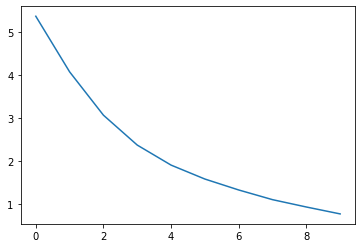

In [9]:
import matplotlib.pyplot as plt
plt.plot(history)